Optimize MobileNetV2 hyperparameters. L2 regularization is added to the Dense layer with a coefficient of 0.01

In [1]:
from typing import Tuple, Callable
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.applications import MobileNetV2
from keras.engine.training import Model
import functools
import os
import numpy as np
import pickle
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Model Defining:

In [2]:
def get_mobilenetv2_full_tune_model_alpha_1_4_concatenated_regularised(_num_classes) \
        -> Tuple[Model, Model, int, Callable]:
    """Additional training of all MobileNetV2 layers, alpha = 1.4. MobileNetV2 layers are directly included. Model is regularized."""
    # If imagenet weights are being loaded, alpha can be one of `0.35`, `0.50`, `0.75`, `1.0`, `1.3` or `1.4` only.
    image_size = 224
    channels_count = 3
    initial_model: Model = MobileNetV2(weights='imagenet', alpha=1.4, include_top=False,
                                       input_shape=(image_size, image_size, channels_count))

    
    initial_model.trainable = True
    for i, layer in enumerate(initial_model.layers):
        layer.trainable = True

    # We include MobileNetV2 layers directly in the final model.
    initial_model_output = initial_model.output
    x = layers.GlobalAveragePooling2D()(initial_model_output)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    predictions = layers.Dense(_num_classes, activation='softmax')(x)

    model = Model(initial_model.input, predictions)

    return model, initial_model, image_size, keras.applications.mobilenet_v2.preprocess_input

# ----------------------------------------------------------------------------------------------------------------------
def get_callbacks_list(_early_stopping_patience, _reduce_lr_on_plateau_factor, _reduce_lr_on_plateau_patience):
    """Get callbacks for a model"""
    return [
        keras.callbacks.EarlyStopping(
            monitor='val_acc',
            patience=_early_stopping_patience
        ),
        keras.callbacks.ModelCheckpoint(
            verbose=1,
            filepath='best_model.h5',
            monitor='val_loss',
            save_best_only=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            verbose=1,
            monitor='val_loss',
            factor=_reduce_lr_on_plateau_factor,
            patience=_reduce_lr_on_plateau_patience
        ),
    ]

In [3]:
batch_size = 32
init_lr = 0.01
momentum = 0.9
epochs = 80
optimazer = keras.optimizers.SGD(lr=init_lr, momentum=momentum)
# optimazer = keras.optimizers.Adam(lr=init_lr)
# Data directories:
train_dir = 'data_preprocessing/Cropped_images/'
# ----------------------------------------------------------------------------------------------------------------------
# Find out the number of task classes by the number of directories in the training folder.:
num_classes = len(os.listdir(train_dir))

# Callback Settings:
early_stopping_patience = 10
reduce_lr_on_plateau_factor = 0.2
reduce_lr_on_plateau_patience = 3

# Selected model:
model_function = get_mobilenetv2_full_tune_model_alpha_1_4_concatenated_regularised
# We obtain the complete model, convolutional basis, image size and the function of preprocessing input images:
model, conv_base, image_size, preprocess_function = model_function(num_classes)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 48) 1296        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 48) 192         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [4]:
# ----------------------------------------------------------------------------------------------------------------------
# Metric for top 5 accuracy
top10_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=10)
top10_acc.__name__ = 'top10_acc'

# Compile the model:
model.compile(loss='categorical_crossentropy', optimizer=optimazer, metrics=['accuracy', top10_acc])


### Data Preprocessing:

In [5]:
# ----------------------------------------------------------------------------------------------------------------------
# Create Generators:
# Expand training data.
# Use only preprocess_function, without any other preprocessing of pixel values ​​and channels.
image_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_function,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.1,
    fill_mode='nearest')

train_generator = image_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
train_images_count = len(train_generator.filenames)

# validation data is not expandable.
validation_generator = image_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
validation_images_count = len(validation_generator.filenames)


with open('classes_name.pickle', 'wb') as handle:
    pickle.dump(validation_generator.class_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

Found 10816 images belonging to 196 classes.
Found 1112 images belonging to 196 classes.


### Model Training

In [6]:
# ----------------------------------------------------------------------------------------------------------------------
# Model Training:
train_steps = len(train_generator.filenames) // batch_size
validation_steps = len(validation_generator.filenames) // batch_size
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=get_callbacks_list(early_stopping_patience, reduce_lr_on_plateau_factor, reduce_lr_on_plateau_patience)
)

Epoch 1/80
338/338 [==============================] - 362s 1s/step - loss: 10.7328 - acc: 0.3092 - top10_acc: 0.6092 - val_loss: 7.7384 - val_acc: 0.1857 - val_top10_acc: 0.5515

Epoch 00001: val_loss improved from inf to 7.73839, saving model to best_model.h5
Epoch 2/80
338/338 [==============================] - 389s 1s/step - loss: 3.3388 - acc: 0.6955 - top10_acc: 0.9528 - val_loss: 5.2767 - val_acc: 0.1944 - val_top10_acc: 0.6444

Epoch 00002: val_loss improved from 7.73839 to 5.27673, saving model to best_model.h5
Epoch 3/80
338/338 [==============================] - 378s 1s/step - loss: 1.4627 - acc: 0.8163 - top10_acc: 0.9839 - val_loss: 3.2625 - val_acc: 0.3519 - val_top10_acc: 0.7870

Epoch 00003: val_loss improved from 5.27673 to 3.26252, saving model to best_model.h5
Epoch 4/80
338/338 [==============================] - 362s 1s/step - loss: 0.8659 - acc: 0.8736 - top10_acc: 0.9925 - val_loss: 2.1198 - val_acc: 0.5472 - val_top10_acc: 0.9065

Epoch 00004: val_loss improved fr

In [9]:
validation_score = model.evaluate_generator(validation_generator, steps=validation_steps)
print('Validation loss: ', validation_score[0])
print('Validation acc:  ', validation_score[1])
print('Validation top 10 score:  ', validation_score[2])

Validation loss:  0.2837304408903475
Validation acc:   0.9351851851851852
Validation top 10 score:   0.9916666666666667


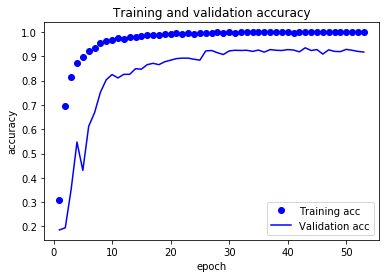

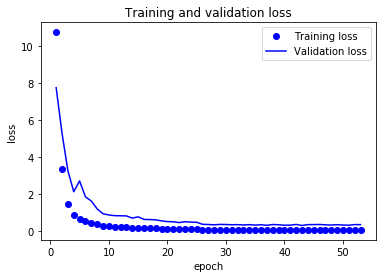

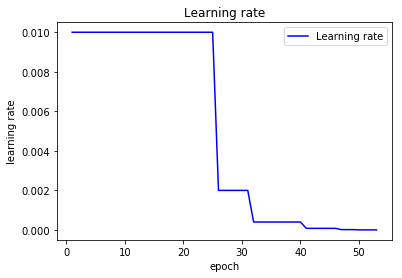

In [10]:
def draw_training_info_plots(_history):
    """Draw loss graphs at the training and validation stage"""
    acc = _history.history['acc']
    val_acc = _history.history['val_acc']
    loss = _history.history['loss']
    val_loss = _history.history['val_loss']

    epochs_plot = range(1, len(acc) + 1)
    plt.plot(epochs_plot, acc, 'bo', label='Training acc')
    plt.plot(epochs_plot, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs_plot, loss, 'bo', label='Training loss')
    plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    if 'lr' in _history.history:
        learning_rate = _history.history['lr']
        plt.plot(epochs_plot, learning_rate, 'b', label='Learning rate')
        plt.title('Learning rate')
        plt.xlabel('epoch')
        plt.ylabel('learning rate')
        plt.legend()
        plt.show()
    return

draw_training_info_plots(history)

In [11]:
# model image saving
from keras.utils import plot_model
# Draw an image with a printout of the model structure:
plot_model(conv_base, show_shapes=True, to_file='conv_base.png')
plot_model(model, show_shapes=True, to_file='model.png')

### Testing on Image

In [1]:
from keras.preprocessing import image
from keras.models import load_model
import functools
import pickle
import keras
import numpy as np
# ----------------------------------------------------------------------------------------------------------------------
# Metric for top 5 accuracy
top10_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=10)
top10_acc.__name__ = 'top10_acc'

model = load_model('model/best_model_top10.h5',custom_objects={'top10_acc': top10_acc})

with open('classes_name.pickle', 'rb') as handle:
    classes_name = pickle.load(handle)

Using TensorFlow backend.


[['Volvo 240 Sedan 1993' '72.694984']
 ['AM General Hummer SUV 2000' '12.358813']
 ['Volkswagen Golf Hatchback 1991' '1.0848004']
 ['Lamborghini Diablo Coupe 2001' '1.0669779']
 ['Ford GT Coupe 2006' '0.9957726']]


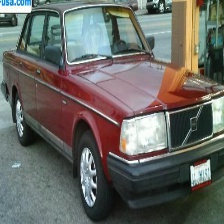

In [3]:
#Volvo 240 Sedan 1993/03227.jpg
#top 5 acc
#Volkswagen Golf Hatchback 1991/00786.jpg
#Nissan NV Passenger Van 2012/07160.jpg
#Nissan NV Passenger Van 2012/02358.jpg
img_path='data_preprocessing/Cropped_images/Volvo 240 Sedan 1993/03227.jpg'
image_size=224
img = image.load_img(img_path, target_size=(image_size, image_size))

x = image.img_to_array(img)
prediction=model.predict(x.reshape(1,image_size,image_size,3))

prediction_index_5=prediction.reshape(-1,).argsort()[-5:][::-1]
print (np.c_[np.array(list((classes_name.keys())))[prediction_index_5],prediction.reshape(-1,)[prediction_index_5]*100])
img